<a href="https://colab.research.google.com/github/MPGarg/Session-4/blob/main/EVA8S4E1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Attempt 1:**

Target:
*   Get the set-up right
*   Set Transforms (with Image Normalization)
*   Set Data Loader
*   Set Basic Working Code
*   Set Basic Training  & Test Loop

Results:
*   Total Parameters: 6,969,866
*   Best Training Accuracy: 99.87%
*   Best Test Accuracy: 99.25%

Analysis:
*   Model is overfitting. It can be inferred from training accuracy that it has nearly learnt (what it can) but test accuracy is still low and has not reached our target.
*   In nearly all epochs training accuracy is more than testing accuracy. Model has started remembering training data and is resulting in lower test accuracy. 
*   Parameters in this model need to be reduced and regularized to make the model learn better.

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Transformations

*   Image Normalization


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std  
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create.
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


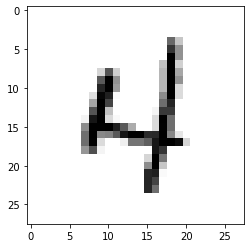

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## More Images

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

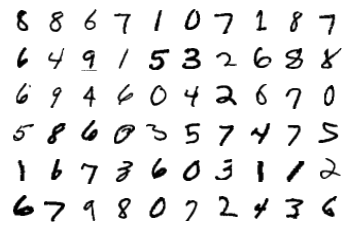

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

Basic working model with Train & Test Validations

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        ) # output_size = 26 RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        ) # output_size = 24 RF = 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        ) # output_size = 22 RF = 7

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11 RF = 8

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        ) # output_size = 9 RF = 12

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        ) # output_size = 7 RF = 16

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        ) # output_size = 5 RF = 20

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        ) # output_size = 3 RF = 24

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=10, kernel_size=(3, 3), padding=0),
        ) # output_size = 1 RF = 28 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,856
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8            [-1, 256, 9, 9]         295,168
              ReLU-9            [-1, 256, 9, 9]               0
           Conv2d-10            [-1, 256, 7, 7]         590,080
             ReLU-11            [-1, 256, 7, 7]               0
           Conv2d-12            [-1, 512, 5, 5]       1,180,160
             ReLU-13            [-1, 512, 5, 5]               0
           Conv2d-14           [-1

# Training and Testing

We have 6.9M params for this model

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and Test of our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.13099144399166107 Batch_id=468 Accuracy=77.52: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]



Test set: Average loss: 0.0751, Accuracy: 9771/10000 (97.71%)

EPOCH: 2


Loss=0.022399576380848885 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]



Test set: Average loss: 0.0460, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.019438745453953743 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]



Test set: Average loss: 0.0340, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.007402174640446901 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:19<00:00, 24.19it/s]



Test set: Average loss: 0.0464, Accuracy: 9852/10000 (98.52%)

EPOCH: 5


Loss=0.007542245090007782 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]



Test set: Average loss: 0.0383, Accuracy: 9879/10000 (98.79%)

EPOCH: 6


Loss=0.07706504315137863 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]



Test set: Average loss: 0.0427, Accuracy: 9869/10000 (98.69%)

EPOCH: 7


Loss=0.015483160503208637 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]



Test set: Average loss: 0.0339, Accuracy: 9888/10000 (98.88%)

EPOCH: 8


Loss=0.04452897980809212 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]



Test set: Average loss: 0.0453, Accuracy: 9863/10000 (98.63%)

EPOCH: 9


Loss=0.004044099245220423 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:19<00:00, 23.64it/s]



Test set: Average loss: 0.0282, Accuracy: 9914/10000 (99.14%)

EPOCH: 10


Loss=0.012648425996303558 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:18<00:00, 24.70it/s]



Test set: Average loss: 0.0315, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.002261696383357048 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:19<00:00, 24.62it/s]



Test set: Average loss: 0.0342, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.0007293191738426685 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]



Test set: Average loss: 0.0335, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.09051350504159927 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]



Test set: Average loss: 0.0299, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.017481030896306038 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]



Test set: Average loss: 0.0344, Accuracy: 9911/10000 (99.11%)

EPOCH: 15


Loss=0.00041252514347434044 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]



Test set: Average loss: 0.0300, Accuracy: 9924/10000 (99.24%)



In [ ]:
train_losses1 = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

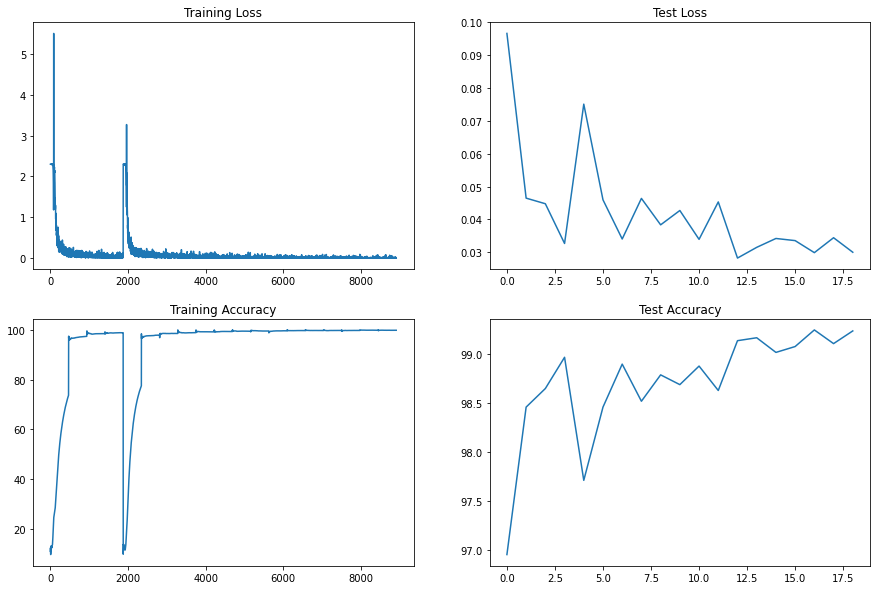

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")